<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


In [179]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import datetime
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, make_scorer

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = ('/home/truename/Documents/capstone_user_identification')

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [4]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [5]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [7]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [8]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [4]:
def write_answer_to_file(answer, file_address):
    with open(file_address, 'w') as out_f:
        out_f.write(str(answer))

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

In [40]:
scores_train = cross_val_score(knn, X_train, y_train, cv=skf, scoring='accuracy')
print(scores_train,"Accuracy train: %0.3f (*/- %0.3f)" % (scores_train.mean(), scores_train.std()* 2))
knn.fit(X_train,y_train)
y_predicted = knn.predict(X_valid)
knn_accuracy = accuracy_score(y_valid, y_predicted)
print("Accuracy train: %0.3f" % knn_accuracy)

[ 0.55951294  0.568466    0.55643685] Accuracy train: 0.561 (*/- 0.010)
Accuracy train: 0.585


**Запишите в файл *answer4_1.txt* доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [39]:
write_answer_to_file("0.561 0.585",
                     'answer4_1.txt')

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
forest = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1, random_state=17)

In [91]:
scorer = make_scorer(accuracy_score)
scores_train = cross_val_score(forest, X_train, y_train, cv=skf, scoring = scorer)
#print(scores_train,"Accuracy train: %0.3f (*/- %0.3f)" % (scores_train.mean(), scores_train.std()* 2))

forest.fit(X_train,y_train)
print(forest.oob_score_)
y_predicted = forest.predict(X_valid)
forest_accuracy = accuracy_score(y_valid, y_predicted)
print("Accuracy valid: %0.5f" % forest_accuracy)

0.724141434668
Accuracy valid: 0.73714


**Запишите в файл *answer4_2.txt* доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке на и отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [90]:
write_answer_to_file("0.724 0.737",
                     'answer4_2.txt')

In [92]:
!cat answer4_2.txt

0.724 0.737

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [93]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [94]:
logit = LogisticRegression(random_state=17, n_jobs=-1)

In [95]:
scores_train = cross_val_score(logit, X_train, y_train, cv=skf)
print(scores_train,"Accuracy train: %0.3f (*/- %0.3f)" % (scores_train.mean(), scores_train.std()* 2))
logit.fit(X_train,y_train)
y_predicted = logit.predict(X_valid)
logit_accuracy = accuracy_score(y_valid, y_predicted)
print("Accuracy train: %0.3f" % logit_accuracy)

[ 0.75494673  0.76913693  0.75716901] Accuracy train: 0.760 (*/- 0.012)
Accuracy train: 0.782


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [114]:
np.logspace(-4, 7, 10)

array([  1.00000000e-04,   1.66810054e-03,   2.78255940e-02,
         4.64158883e-01,   7.74263683e+00,   1.29154967e+02,
         2.15443469e+03,   3.59381366e+04,   5.99484250e+05,
         1.00000000e+07])

In [115]:
%%time
logit_c_values1 = np.logspace(-4, 7, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, cv = skf, verbose=1, n_jobs=-1, multi_class='multinomial', random_state=17)
#logit_grid_searcher1 = LogisticRegressionCV(n_jobs=-1, multi_class='multinomial', random_state=17)
logit_grid_searcher1.fit(X_train, y_train)


#logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
#logit_searcher.fit(X_poly, y)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.0s finished


CPU times: user 1.69 s, sys: 652 ms, total: 2.34 s
Wall time: 16.7 s


In [122]:
#[value for key, value in logit_grid_searcher1.scores_.items()]
logit_grid_searcher1.scores_[1].mean(axis=0).argmax()
#print(np.count_nonzero(logit_grid_searcher1.coef_))  # 20 non-zero coefficients

# check which value of C was selected
#print(logit_grid_searcher1.C_)  # [ 0.01]
#logit_grid_searcher1.score(X_train, y_train)

# compare lr_cv.coef_ to lr_01.coef_
#print(logit_grid_searcher1.coef_)

3

In [32]:
cross_val_score(logit_grid_searcher1, X_train, y_train, cv=skf)

array([ 0.75251142,  0.76913693,  0.75472849])

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [136]:
logit_mean_cv_scores1 = [logit_grid_searcher1.scores_[s].mean(axis=0) for s in logit_grid_searcher1.scores_][1]
logit_mean_cv_scores1

array([ 0.31822225,  0.53444626,  0.69498648,  0.75868973,  0.75625417,
        0.74446876,  0.74193102,  0.7390844 ,  0.73898358,  0.73715499])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [137]:
print(logit_mean_cv_scores1.max(),logit_mean_cv_scores1.argmax())

0.758689725398 3


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

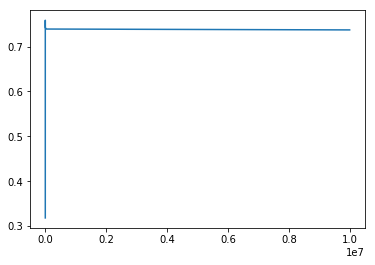

In [138]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(3, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [143]:
%%time
logit_c_values2 = np.linspace(3, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, cv = skf, n_jobs=-1, multi_class='multinomial', random_state=17)
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 1.95 s, sys: 672 ms, total: 2.62 s
Wall time: 39.6 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [144]:
logit_mean_cv_scores2 = [logit_grid_searcher2.scores_[s].mean(axis=0) for s in logit_grid_searcher2.scores_][1]
logit_mean_cv_scores2

array([ 0.75981096,  0.75737193,  0.75737258,  0.75727111,  0.75717004,
        0.75666148,  0.75655976,  0.75635725,  0.75615409,  0.75605265,
        0.75595124,  0.75564682,  0.75544388,  0.75534241,  0.75524072,
        0.75473318,  0.75432689,  0.75422558,  0.75432726,  0.75432742])

In [317]:
#logit_grid_searcher2.scores_[1]#.max() #0.76913693199146083
np.linspace(3, 7, 20)

array([ 3.        ,  3.21052632,  3.42105263,  3.63157895,  3.84210526,
        4.05263158,  4.26315789,  4.47368421,  4.68421053,  4.89473684,
        5.10526316,  5.31578947,  5.52631579,  5.73684211,  5.94736842,
        6.15789474,  6.36842105,  6.57894737,  6.78947368,  7.        ])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [145]:
print(logit_mean_cv_scores2.max(),logit_mean_cv_scores2.argmax())

0.759810955896 0


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

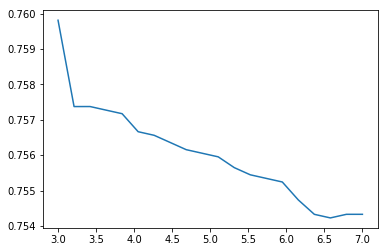

In [146]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [147]:
logit_grid_searcher2.predict(X_train)

array([6, 2, 8, ..., 2, 6, 6])

In [152]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
logit_cv_acc

0.78051671012088175

**Запишите в файл *answer4_3.txt* доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [153]:
write_answer_to_file("0.760 0.781",
                     'answer4_3.txt')

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [155]:
from sklearn.svm import LinearSVC

In [156]:
svm = LinearSVC(C=1,random_state=17)
scores_train = cross_val_score(svm, X_train, y_train, cv=skf)
print(scores_train,"Accuracy train: %0.3f (*/- %0.3f)" % (scores_train.mean(), scores_train.std()* 2))
svm.fit(X_train,y_train)
y_predicted = svm.predict(X_valid)
print("Accuracy train: %0.3f" % accuracy_score(y_valid, y_predicted))

[ 0.74672755  0.76029277  0.75320317] Accuracy train: 0.753 (*/- 0.011)
Accuracy train: 0.776


**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [159]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm,svm_params1)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 52.6 s, sys: 0 ns, total: 52.6 s
Wall time: 52.6 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [167]:
print(svm_grid_searcher1.best_score_,svm_grid_searcher1.best_index_)

0.701280227596 8


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

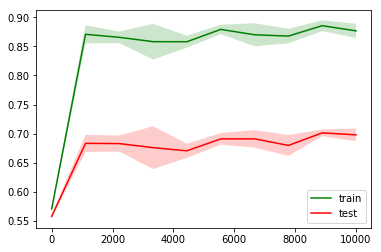

In [168]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [169]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm,svm_params2)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 1min 50s, sys: 4 ms, total: 1min 50s
Wall time: 1min 50s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [170]:
print(svm_grid_searcher2.best_score_,svm_grid_searcher2.best_index_)

0.765901239585 4


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

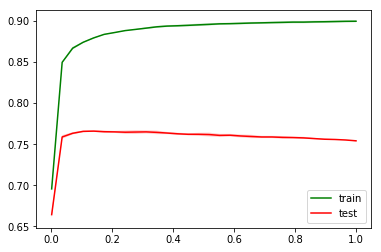

In [171]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [172]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid))
svm_cv_acc

0.78193884806826264

**Запишите в файл *answer4_4.txt* доли правильных ответов для svm_grid_searcher2 на кросс-валидации для лучшего значения параметра С и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [174]:
write_answer_to_file("0.766 0.782",
                     'answer4_4.txt')

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [261]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    #start = datetime.datetime.now()
    
    with open(path_to_X_pickle, 'rb') as pkl_file:
        X_sparse = pickle.load(pkl_file)
    with open(path_to_y_pickle, 'rb') as pkl_file:
        y = pickle.load(pkl_file)
    #print(X_sparse.shape, y.shape)
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, test_size=test_size, random_state=random_state, stratify=y)
    #print(y_train.tolist())
    scores_train = cross_val_score(estimator=estimator, X=X_train, y=y_train.tolist(), cv=cv, scoring='accuracy', n_jobs=-1)
    cv_mean = scores_train.mean()
    estimator.fit(X_train,y_train.tolist())
    valid_acc = accuracy_score(y_valid.tolist(), estimator.predict(X_valid))
    #end = datetime.datetime.now()
    #elapsed = end - start
    return cv_mean, valid_acc#, elapsed.seconds,":",elapsed.microseconds

**Убедитесь, что функция работает.**

In [247]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7633647423247526, 0.78193884806826264)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [200]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [248]:
model_assessment(svm_grid_searcher2.best_estimator_, \
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users_s15_w5.pkl'), \
                os.path.join(PATH_TO_DATA, 'y_10users_s15_w5.pkl'), skf, random_state=17, test_size=0.3)

(0.86866242197354693, 0.87648174490279751)

In [250]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s%s_w%s.pkl'%(session_length,window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s%s_w%s.pkl'%(session_length,window_size))
        #print(path_to_X_pkl,path_to_y_pkl)
        print(session_length,window_size,model_assessment(svm_grid_searcher2.best_estimator_, \
                 path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3))

15 10 (0.82178844758549741, 0.83953543493718896)
10 10 (0.7633647423247526, 0.78193884806826264)
15 7 (0.84658956127225782, 0.85564957690393229)
10 7 (0.7974432837736799, 0.80852828936452625)
7 7 (0.7541989647152324, 0.76223660195785636)
15 5 (0.86866242197354693, 0.87648174490279751)
10 5 (0.81821117463435622, 0.82491702228544339)
7 5 (0.7754306414988501, 0.78733997155049784)
5 5 (0.72665511718144848, 0.73707918444760545)
CPU times: user 32.9 s, sys: 8 ms, total: 32.9 s
Wall time: 33 s


**Запишите в файл *answer4_5.txt* доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [249]:
write_answer_to_file("0.869 0.876", 
                     'answer4_5.txt')

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [251]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_150users_s%s_w%s.pkl'%(session_length,window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_150users_s%s_w%s.pkl'%(session_length,window_size))
        #print(path_to_X_pkl,path_to_y_pkl)
        print(session_length,window_size,model_assessment(svm_grid_searcher2.best_estimator_, \
                 path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3))

5 5 (0.4089831514708388, 0.42203241349102061)
7 7 (0.4359773692874882, 0.45307763054808053)
10 10 (0.46023737201535692, 0.48340874811463047)
CPU times: user 21min 26s, sys: 3.47 s, total: 21min 30s
Wall time: 21min 30s


**Запишите в файл *answer4_6.txt* доли правильных ответов для LinearSVC с настроенным параметром C и выборки *X_sparse_150users*. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [253]:
write_answer_to_file("0.460 0.483", 
                     'answer4_6.txt')

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [254]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [255]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [318]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[3.84210526], multi_class='ovr', n_jobs=-1,random_state=17)
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 4min 53s, sys: 1min 26s, total: 6min 20s
Wall time: 7min 41s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [319]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format (user_id,logit_cv_150users.scores_[user_id].mean()))

User 1, CV score: 0.995902275558
User 2, CV score: 0.996298876698
User 3, CV score: 0.995245682969
User 4, CV score: 0.991669808408
User 5, CV score: 0.990334696917
User 6, CV score: 0.994255197601
User 7, CV score: 0.993681763524
User 8, CV score: 0.985882920146
User 9, CV score: 0.997987637548
User 10, CV score: 0.99520441899
User 11, CV score: 0.994422265803
User 12, CV score: 0.993567256383
User 13, CV score: 0.996736703571
User 14, CV score: 0.994724552284
User 15, CV score: 0.996309036146
User 16, CV score: 0.996298999221
User 17, CV score: 0.99043926014
User 18, CV score: 0.994422050271
User 19, CV score: 0.994547215683
User 20, CV score: 0.991325545488
User 21, CV score: 0.981160297482
User 22, CV score: 0.996903537355
User 23, CV score: 0.994640486191
User 24, CV score: 0.990971083926
User 25, CV score: 0.99665333342
User 26, CV score: 0.994296941518
User 27, CV score: 0.994974728127
User 28, CV score: 0.991334894729
User 29, CV score: 0.984976261613
User 30, CV score: 0.99707

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [320]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = {}
for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id]=logit_cv_150users.scores_[user_id].mean()-(len(y_train_150[y_train_150!=user_id])/len(y_train_150))
print(acc_diff_vs_constant)

{1: 0.011499744097461684, 2: 0.00059443621538868285, 3: 0.00084450690367543491, 4: 0.0069544934869048003, 5: 0.0023872862430281971, 6: -0.00019810904157235854, 7: 0.0011364359872279017, 8: 0.001970416105691708, 9: 0.0008652453797893811, 10: 0.001376679267264147, 11: 0.00027131650472533853, 12: 0.001522382382920684, 13: -0.00018759240554155898, 14: -0.0001353728564988943, 15: -4.1823486856551462e-05, 16: 0.00010453131749632583, 17: 0.00036492193811377138, 18: 0.00027110097344806849, 19: -0.00019802218864795051, 20: 0.00088629324923306108, 21: 0.0041603079086129924, 22: 0.00088631341270750674, 23: 0.0074229035898963902, 24: 0.00096972853093646449, 25: 0.00070909228498250432, 26: 0.00063601964058324079, 27: 0.00091761386709154902, 28: 0.0038253808992421146, 29: 0.0053801693210113744, 30: -4.1857896725061572e-05, 31: 0.00026072024092205215, 32: 0.00022940091591672207, 33: 0.00019825581981358642, 34: 0.00028167479586038713, 35: 0.00036466648660471446, 36: 0.0013864636099155669, 37: 0.001094

In [323]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
print(num_better_than_default)
print(num_better_than_default/len(np.unique(y_train_150)))

119
0.793333333333
0.786666666667
0.78
0.773333333333
0.806666666667
0.813333333333


In [2]:
print(118./150)
print(117./150)
print(116./150)
print(121./150)
print(122./150)
print(123./150)
print(124./150)

0.786666666667
0.78
0.773333333333
0.806666666667
0.813333333333
0.82
0.826666666667


**Запишите в файл *answer4_7.txt* долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой. **

In [6]:
write_answer_to_file("0.807", 
                     'answer4_7.txt')

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [300]:
y_binary_128 = [1 if i == 128 else 0 for i in y_150users]

In [301]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [305]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator,X=X_train,y=y_train,cv=skf, n_jobs=-1,random_state=17,train_sizes=train_sizes)

CPU times: user 288 ms, sys: 140 ms, total: 428 ms
Wall time: 5.26 s


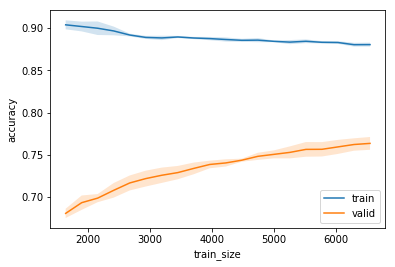

In [306]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
В этом проекте свобода творчества на каждом шаге, а 7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взимному оцениванию. Что еще можно добавить по 4 части проекта:
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей

На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.